In [1]:
# Nifty Time Series Forecasting with Prophet
# ==========================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.dates as mdates

# Set plot styling
plt.style.use('fivethirtyeight')
sns.set_palette("deep")

In [10]:


# Load data
def load_data(file_path):
    """
    Load and preprocess Nifty data
    """
    df = pd.read_csv(file_path)
    
    # Convert datetime to pandas datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Remove timezone information consistently throughout the dataframe
    df['datetime'] = df['datetime'].dt.tz_localize(None)
    
    # Sort by datetime
    df = df.sort_values('datetime')
    
    print(f"Data loaded successfully: {df.shape[0]} records from {df['datetime'].min()} to {df['datetime'].max()}")
    return df

# Display sample data
def display_sample_data(df):
    """
    Display sample data and basic statistics
    """
    print("Sample data:")
    print(df.head())
    
    print("\nData types:")
    print(df.dtypes)
    
    print("\nBasic statistics:")
    print(df.describe())
    
    print("\nMissing values:")
    print(df.isnull().sum())
    
    return

# Extract relevant features and insights
def extract_insights(df):
    """
    Extract insights from the data to understand Nifty's behavior
    """
    # Calculate daily range
    df_day = df.resample('D', on='datetime').agg({
        'high': 'max',
        'low': 'min',
        'open': 'first',
        'close': 'last'
    }).dropna()
    
    df_day['daily_range'] = df_day['high'] - df_day['low']
    df_day['daily_range_percent'] = (df_day['daily_range'] / df_day['open']) * 100
    
    # Calculate weekly range
    df_week = df.resample('W-MON', on='datetime').agg({
        'high': 'max',
        'low': 'min',
        'open': 'first',
        'close': 'last'
    }).dropna()
    
    df_week['weekly_range'] = df_week['high'] - df_week['low']
    df_week['weekly_range_percent'] = (df_week['weekly_range'] / df_week['open']) * 100
    
    # Print weekly range statistics
    print("Weekly range statistics:")
    print(df_week['weekly_range'].describe())
    print("\nWeekly range percentage statistics:")
    print(df_week['weekly_range_percent'].describe())
    
    # Calculate weekly high and low distribution
    weekly_high_pct = df_week['high'].pct_change().dropna() * 100
    weekly_low_pct = df_week['low'].pct_change().dropna() * 100
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot daily range percentage distribution
    sns.histplot(df_day['daily_range_percent'], kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Daily Range Percentage')
    axes[0].set_xlabel('Daily Range (%)')
    axes[0].set_ylabel('Frequency')
    
    # Plot weekly range percentage distribution
    sns.histplot(df_week['weekly_range_percent'], kde=True, ax=axes[1])
    axes[1].set_title('Distribution of Weekly Range Percentage')
    axes[1].set_xlabel('Weekly Range (%)')
    axes[1].set_ylabel('Frequency')
    
    # Plot weekly high and low changes
    axes[2].plot(df_week.index, df_week['weekly_range_percent'], label='Weekly Range %')
    axes[2].set_title('Weekly Range Percentage Over Time')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Range (%)')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return df_day, df_week

# Filter data for Mondays
def filter_monday_data(df):
    """
    Filter data to include only Monday's hourly records
    """
    monday_df = df[df['datetime'].dt.dayofweek == 0].copy()
    print(f"Filtered {monday_df.shape[0]} records for Mondays")
    return monday_df

# Prepare data for Prophet
def prepare_prophet_data(df, target_col):
    """
    Prepare data for Prophet model
    """
    prophet_df = df[['datetime', target_col]].copy()
    
    # Remove timezone information from datetime
    prophet_df['datetime'] = prophet_df['datetime'].dt.tz_localize(None)
    
    prophet_df.columns = ['ds', 'y']
    
    return prophet_df

# Train Prophet model
def train_prophet_model(df, target_col, train_end_date):
    """
    Train Prophet model
    """
    # Ensure train_end_date has no timezone
    if hasattr(train_end_date, 'tz') and train_end_date.tz is not None:
        train_end_date = train_end_date.tz_localize(None)
    
    # Prepare data
    prophet_df = df[['datetime', target_col]].copy()
    
    # Ensure datetime column has no timezone
    prophet_df['datetime'] = prophet_df['datetime'].dt.tz_localize(None)
    
    prophet_df.columns = ['ds', 'y']
    
    # Split into train and test - ensure comparison with same timezone type
    train_df = prophet_df[prophet_df['ds'] <= train_end_date].copy()
    test_df = prophet_df[prophet_df['ds'] > train_end_date].copy()
    
    print(f"Training on {len(train_df)} samples, testing on {len(test_df)} samples")
    
    # Create and train model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    
    # Fit the model
    model.fit(train_df)
    
    return model, train_df, test_df

# Evaluate model performance
def evaluate_model(model, test_df, forecast):
    """
    Evaluate model performance
    """
    # Merge actual and predicted values
    evaluation_df = test_df.merge(
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], 
        on='ds', 
        how='left'
    )
    
    # Handle NaN values - either drop them or print warning
    nan_count = evaluation_df['yhat'].isna().sum()
    if nan_count > 0:
        print(f"Warning: Found {nan_count} NaN values in predictions. Dropping these records for evaluation.")
        evaluation_df = evaluation_df.dropna(subset=['yhat'])
    
    # If after dropping NaNs we still have data to evaluate
    if len(evaluation_df) > 0:
        # Calculate error metrics
        mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
        rmse = np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat']))
        
        # Handle potential division by zero in MAPE calculation
        non_zero_mask = evaluation_df['y'] != 0
        if non_zero_mask.any():
            mape = np.mean(np.abs((evaluation_df['y'][non_zero_mask] - evaluation_df['yhat'][non_zero_mask]) / 
                                  evaluation_df['y'][non_zero_mask])) * 100
        else:
            mape = float('nan')
            print("Warning: Cannot calculate MAPE due to zero values in actual data.")
        
        print(f"Model Performance Metrics:")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%" if not np.isnan(mape) else "MAPE: Not calculable")
    else:
        print("Cannot evaluate model: No matching data points between test set and predictions.")
        mae = rmse = mape = float('nan')
    
    return evaluation_df

# Make predictions
def make_predictions(model, periods, freq, include_history=True):
    """
    Generate future predictions
    """
    future = model.make_future_dataframe(periods=periods, freq=freq, include_history=include_history)
    forecast = model.predict(future)
    
    return forecast

# Plot results
def plot_forecast(model, forecast, df, target_col, train_end_date=None):
    """
    Plot forecast results
    """
    fig = plt.figure(figsize=(16, 8))
    
    # Plot the actual values
    plt.plot(df['datetime'], df[target_col], 'ko', markersize=2, label='Actual')
    
    # Plot the forecast
    plt.plot(forecast['ds'], forecast['yhat'], 'steelblue', linewidth=2, label='Forecast')
    
    # Add uncertainty intervals
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                     color='steelblue', alpha=0.2, label='Uncertainty Interval')
    
    # Add train-test separator if provided
    if train_end_date:
        plt.axvline(x=train_end_date, color='r', linestyle='--', label='Train/Test Split')
    
    plt.title(f'Nifty {target_col} Forecast')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return

# Plot components
def plot_components(model, forecast):
    """
    Plot forecast components
    """
    fig = model.plot_components(forecast)
    plt.show()
    
    return

# Generate weekly forecasts
def generate_weekly_forecasts(model, future_weeks=3):
    """
    Generate weekly forecasts for the next 1-3 weeks
    """
    # Create future dataframe for hourly predictions
    future = model.make_future_dataframe(periods=future_weeks*7*24, freq='H')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Get current date (assuming this is a Monday)
    last_date = forecast['ds'].min()
    
    # Make sure last_date has no timezone before adding timedelta
    if hasattr(last_date, 'tz') and last_date.tz is not None:
        last_date = last_date.tz_localize(None)
        
    current_monday = last_date + pd.Timedelta(days=(7-last_date.dayofweek) % 7)
    
    weekly_forecasts = []
    
    # Generate forecasts for each week
    for week in range(future_weeks):
        week_start = current_monday + pd.Timedelta(weeks=week)
        week_end = week_start + pd.Timedelta(days=3)  # End on Thursday
        
        # Filter forecast for this week - ensure all datetimes have consistent timezone handling
        week_forecast = forecast[(forecast['ds'] >= week_start) & 
                               (forecast['ds'] <= week_end + pd.Timedelta(hours=23))]
        
        # Get highest high and lowest low
        highest_high = week_forecast['yhat_upper'].max()
        lowest_low = week_forecast['yhat_lower'].min()
        
        # Store results
        weekly_forecasts.append({
            'week_num': week + 1,
            'week_start': week_start.strftime('%Y-%m-%d'),
            'week_end': week_end.strftime('%Y-%m-%d'),
            'highest_high': highest_high,
            'lowest_low': lowest_low,
            'range': highest_high - lowest_low
        })
    
    weekly_df = pd.DataFrame(weekly_forecasts)
    print("\nWeekly Forecasts (Monday to Thursday):")
    print(weekly_df)
    
    return weekly_df, forecast

# Plot weekly forecast ranges
def plot_weekly_ranges(weekly_df):
    """
    Plot forecasted weekly ranges
    """
    plt.figure(figsize=(12, 6))
    
    # Plot range as bar
    plt.bar(weekly_df['week_num'], weekly_df['range'], alpha=0.7, label='Range')
    
    # Annotate values
    for i, row in weekly_df.iterrows():
        plt.text(row['week_num'], row['highest_high'] + 50, 
                 f"High: {row['highest_high']:.2f}", 
                 ha='center', va='bottom')
        plt.text(row['week_num'], row['lowest_low'] - 50, 
                 f"Low: {row['lowest_low']:.2f}", 
                 ha='center', va='top')
    
    # Mark high and low points
    plt.scatter(weekly_df['week_num'], weekly_df['highest_high'], 
                color='g', marker='^', s=100, label='Predicted High')
    plt.scatter(weekly_df['week_num'], weekly_df['lowest_low'], 
                color='r', marker='v', s=100, label='Predicted Low')
    
    # Connect high and low with lines
    for i, row in weekly_df.iterrows():
        plt.plot([row['week_num'], row['week_num']], 
                 [row['lowest_low'], row['highest_high']], 
                 'k--', alpha=0.5)
    
    plt.xlabel('Week Number')
    plt.ylabel('Nifty Value')
    plt.title('Nifty Weekly Range Forecast (Monday to Thursday)')
    plt.xticks(weekly_df['week_num'])
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return

# Plot actual vs predicted range
def plot_actual_vs_predicted(evaluation_df, actual_df, target_col, weeks=8):
    """
    Plot actual vs predicted ranges for the test period
    """
    # Ensure datetime columns have no timezone
    actual_df_copy = actual_df.copy()
    actual_df_copy['datetime'] = actual_df_copy['datetime'].dt.tz_localize(None)
    
    # Extract actual weekly ranges
    actual_weekly = actual_df_copy.resample('W-MON', on='datetime').agg({
        'high': 'max',
        'low': 'min'
    }).dropna().reset_index()
    
    # Take only the last n weeks
    actual_weekly = actual_weekly.tail(weeks)
    
    # Group predictions by week
    evaluation_df['week'] = evaluation_df['ds'].dt.isocalendar().week
    evaluation_df['year'] = evaluation_df['ds'].dt.isocalendar().year
    
    pred_weekly = evaluation_df.groupby(['year', 'week']).agg({
        'yhat': 'max',
        'yhat_lower': 'min'
    }).reset_index()
    
    # Take only the last n weeks
    pred_weekly = pred_weekly.tail(weeks)
    
    # Prepare plot data
    week_labels = [f"W{i+1}" for i in range(weeks)]
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    # Plot actual ranges
    plt.plot(week_labels, actual_weekly['high'], 'go-', label='Actual High')
    plt.plot(week_labels, actual_weekly['low'], 'ro-', label='Actual Low')
    
    # Plot predicted ranges
    plt.plot(week_labels, pred_weekly['yhat'], 'g--', alpha=0.7, label='Predicted High')
    plt.plot(week_labels, pred_weekly['yhat_lower'], 'r--', alpha=0.7, label='Predicted Low')
    
    # Fill areas
    plt.fill_between(week_labels, actual_weekly['high'], actual_weekly['low'], 
                     color='blue', alpha=0.1, label='Actual Range')
    plt.fill_between(week_labels, pred_weekly['yhat'], pred_weekly['yhat_lower'], 
                     color='purple', alpha=0.1, label='Predicted Range')
    
    plt.title(f'Actual vs Predicted Weekly {target_col} Range')
    plt.xlabel('Week')
    plt.ylabel(target_col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return

# Make predictions for user input
def predict_for_user_input(model, last_price):
    """
    Make predictions based on user input
    """
    print("\nMaking predictions based on current Nifty value:", last_price)
    
    # Create future dataframe for 3 weeks
    future = model.make_future_dataframe(periods=3*7*24, freq='H')
    
    # Make predictions
    forecast = model.predict(future)
    
    # Adjust predictions based on current value
    last_prediction = forecast['yhat'].iloc[0]
    adjustment_factor = last_price / last_prediction
    
    forecast['yhat'] = forecast['yhat'] * adjustment_factor
    forecast['yhat_lower'] = forecast['yhat_lower'] * adjustment_factor
    forecast['yhat_upper'] = forecast['yhat_upper'] * adjustment_factor
    
    # Get current date (assuming this is a Monday)
    last_date = forecast['ds'].min()
    current_monday = last_date + pd.Timedelta(days=(7-last_date.dayofweek) % 7)
    
    weekly_forecasts = []
    
    # Generate forecasts for each week
    for week in range(3):
        week_start = current_monday + pd.Timedelta(weeks=week)
        week_end = week_start + pd.Timedelta(days=3)  # End on Thursday
        
        # Filter forecast for this week
        week_forecast = forecast[(forecast['ds'] >= week_start) & 
                                 (forecast['ds'] <= week_end + pd.Timedelta(hours=23))]
        
        # Get highest high and lowest low
        highest_high = week_forecast['yhat_upper'].max()
        lowest_low = week_forecast['yhat_lower'].min()
        
        # Store results
        weekly_forecasts.append({
            'week_num': week + 1,
            'week_start': week_start.strftime('%Y-%m-%d'),
            'week_end': week_end.strftime('%Y-%m-%d'),
            'highest_high': highest_high,
            'lowest_low': lowest_low,
            'range': highest_high - lowest_low
        })
    
    weekly_df = pd.DataFrame(weekly_forecasts)
    print("\nWeekly Forecasts Based on User Input (Monday to Thursday):")
    print(weekly_df)
    
    # Plot results
    plot_weekly_ranges(weekly_df)
    
    return weekly_df, forecast


Data loaded successfully: 18285 records from 2014-08-12 10:15:00 to 2025-03-19 11:15:00
Sample data:
             datetime     open     high      low   close
0 2014-08-12 10:15:00  7671.25  7673.95  7657.50  7669.9
1 2014-08-12 11:15:00  7670.35  7672.65  7657.10  7664.7
2 2014-08-12 12:15:00  7664.65  7669.30  7654.80  7663.9
3 2014-08-12 13:15:00  7664.05  7676.25  7661.30  7675.7
4 2014-08-12 14:15:00  7675.55  7730.70  7672.45  7723.7

Data types:
datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
dtype: object

Basic statistics:
                            datetime          open          high  \
count                          18285  18285.000000  18285.000000   
mean   2019-12-05 10:17:04.479080960  13510.560202  13533.008212   
min              2014-08-12 10:15:00   6912.800000   6955.600000   
25%              2017-04-13 10:15:00   9036.500000   9062.150000   
50%              2019-12-10 15:15:00

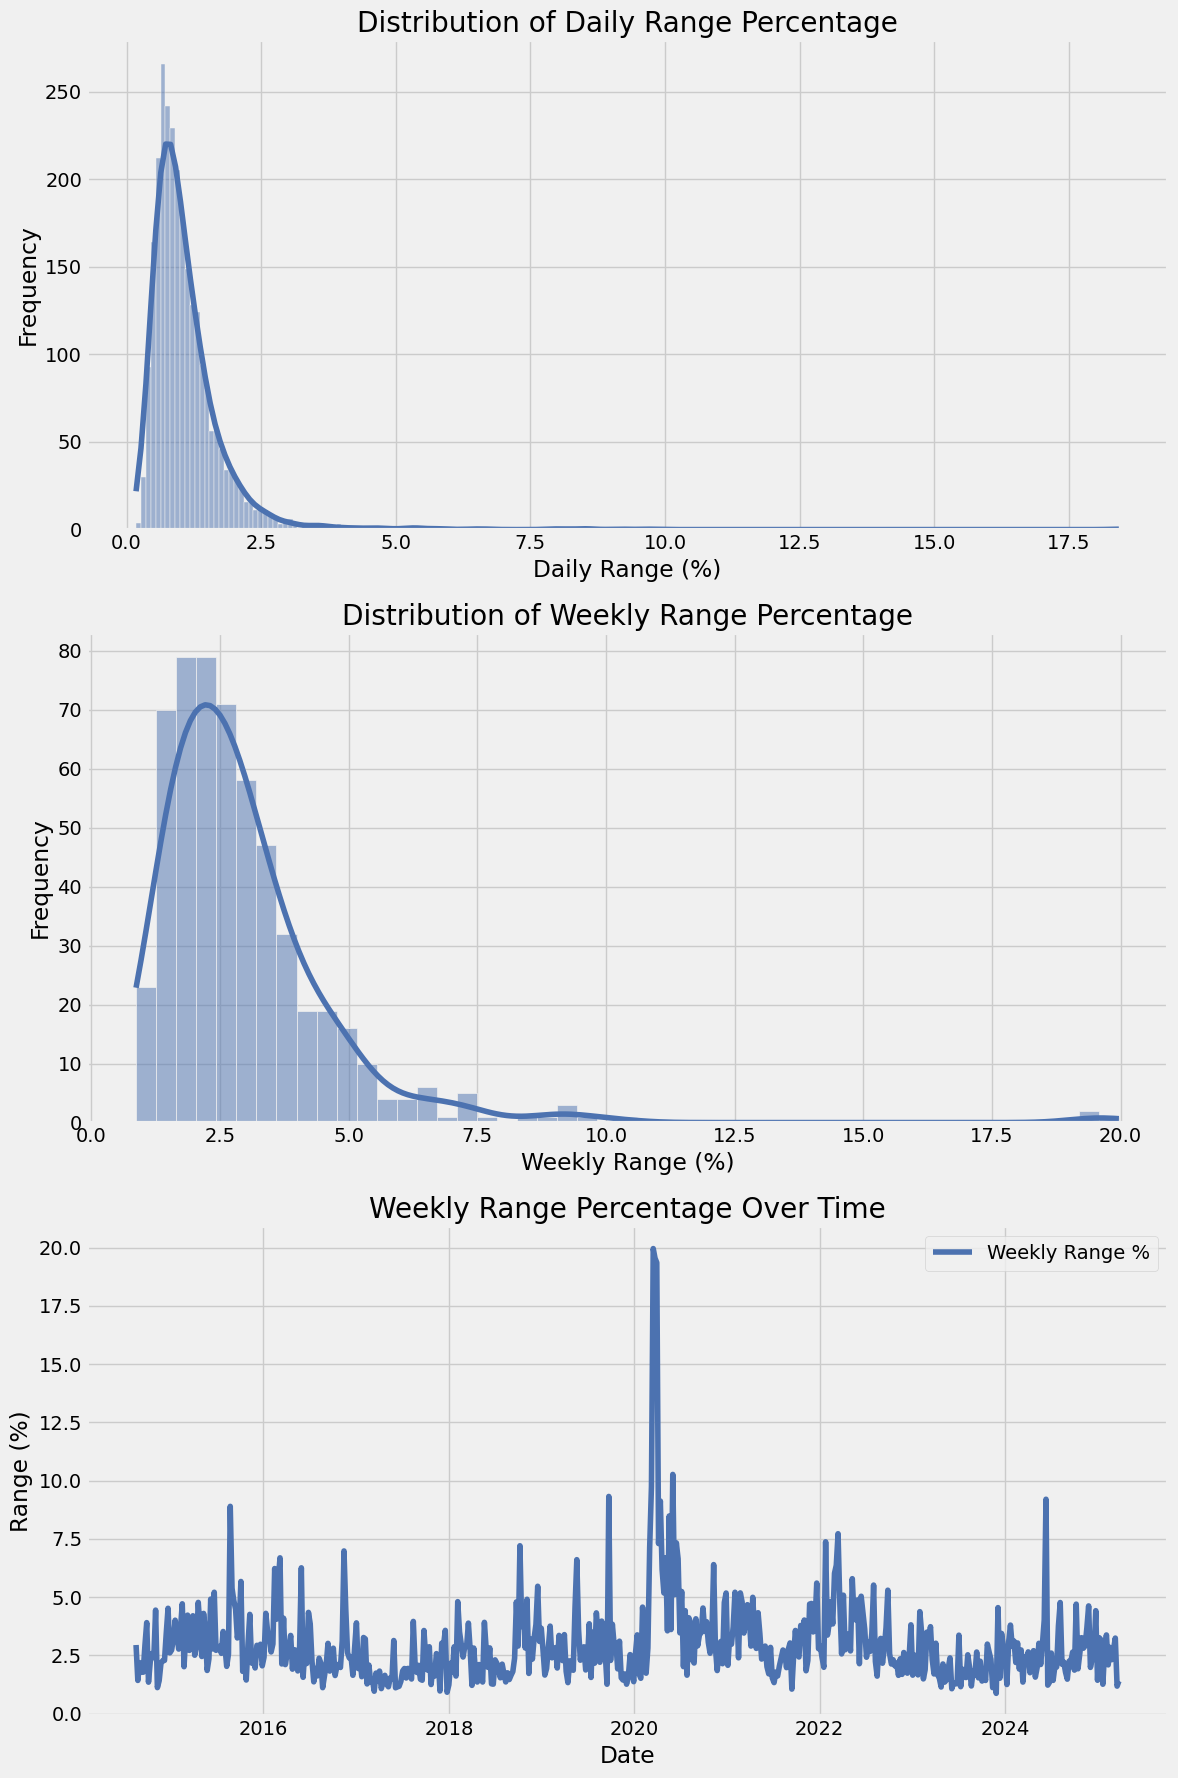

Filtered 3642 records for Mondays
Training on 3579 samples, testing on 63 samples


00:10:40 - cmdstanpy - INFO - Chain [1] start processing
00:10:42 - cmdstanpy - INFO - Chain [1] done processing


Training on 3579 samples, testing on 63 samples


00:10:42 - cmdstanpy - INFO - Chain [1] start processing
00:10:44 - cmdstanpy - INFO - Chain [1] done processing


Model Performance Metrics:
MAE: 2720.88
RMSE: 2764.48
MAPE: 11.92%
Model Performance Metrics:
MAE: 2707.55
RMSE: 2752.00
MAPE: 11.90%


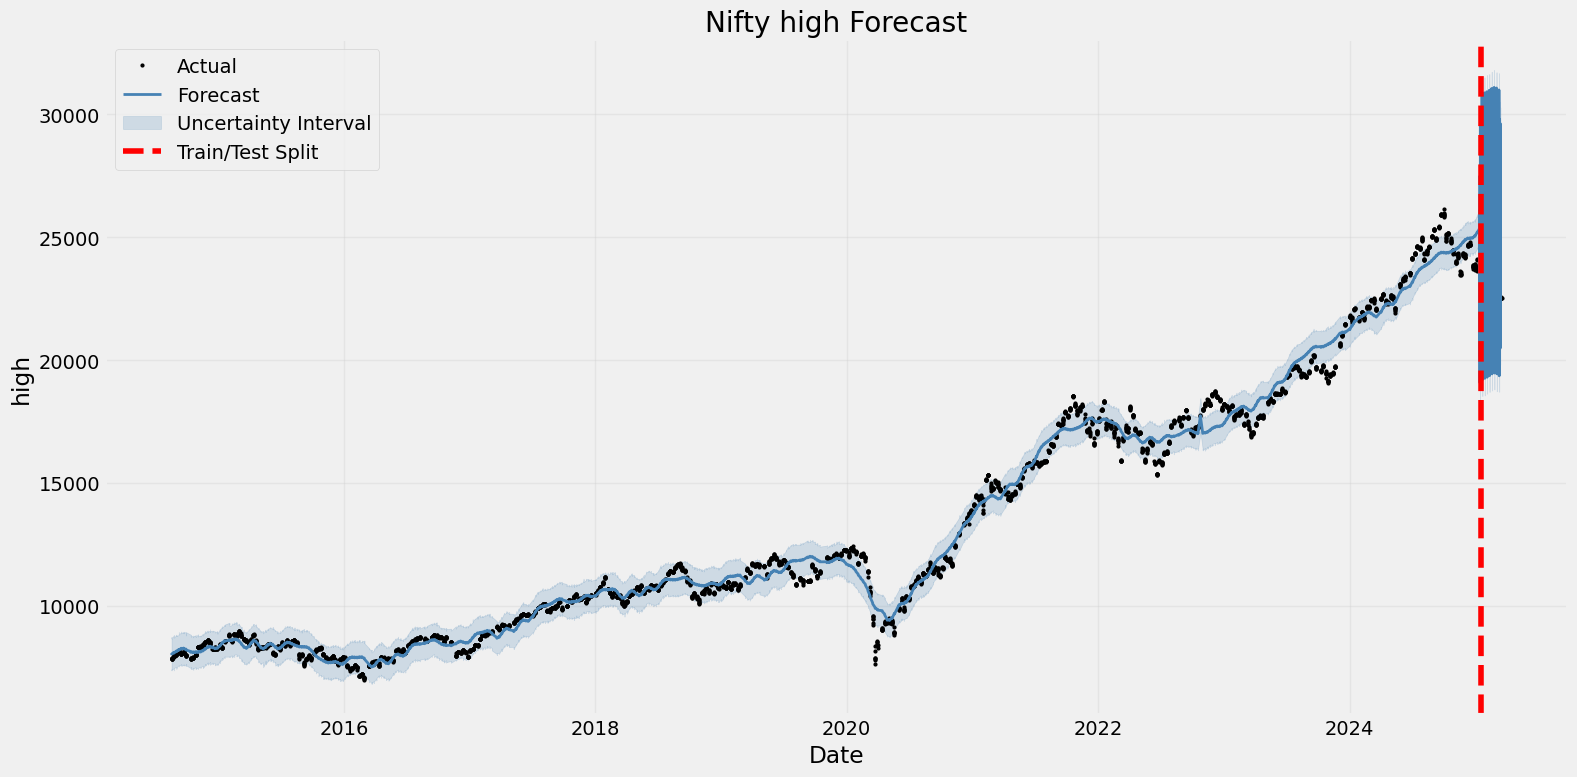

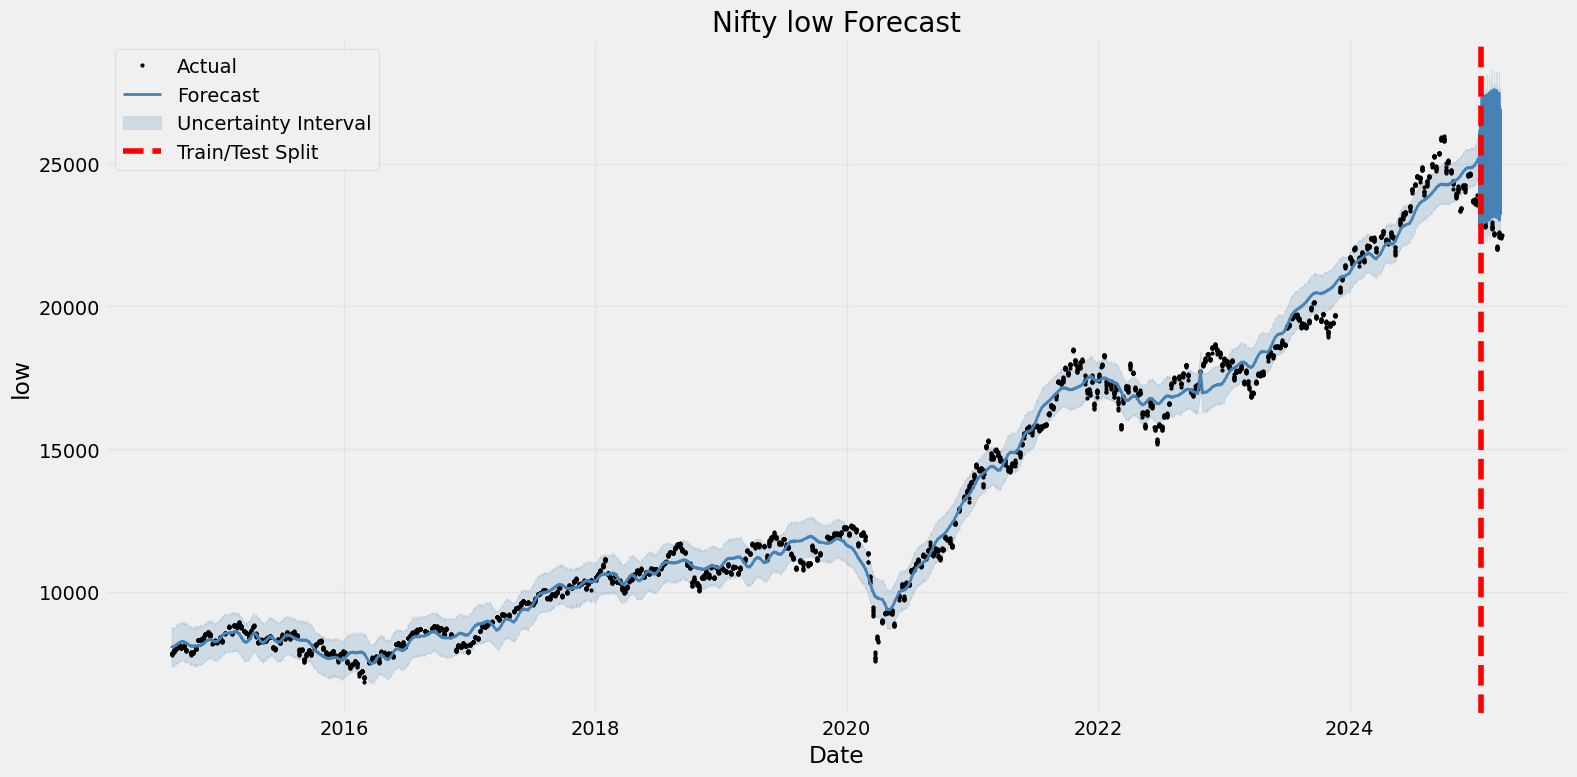

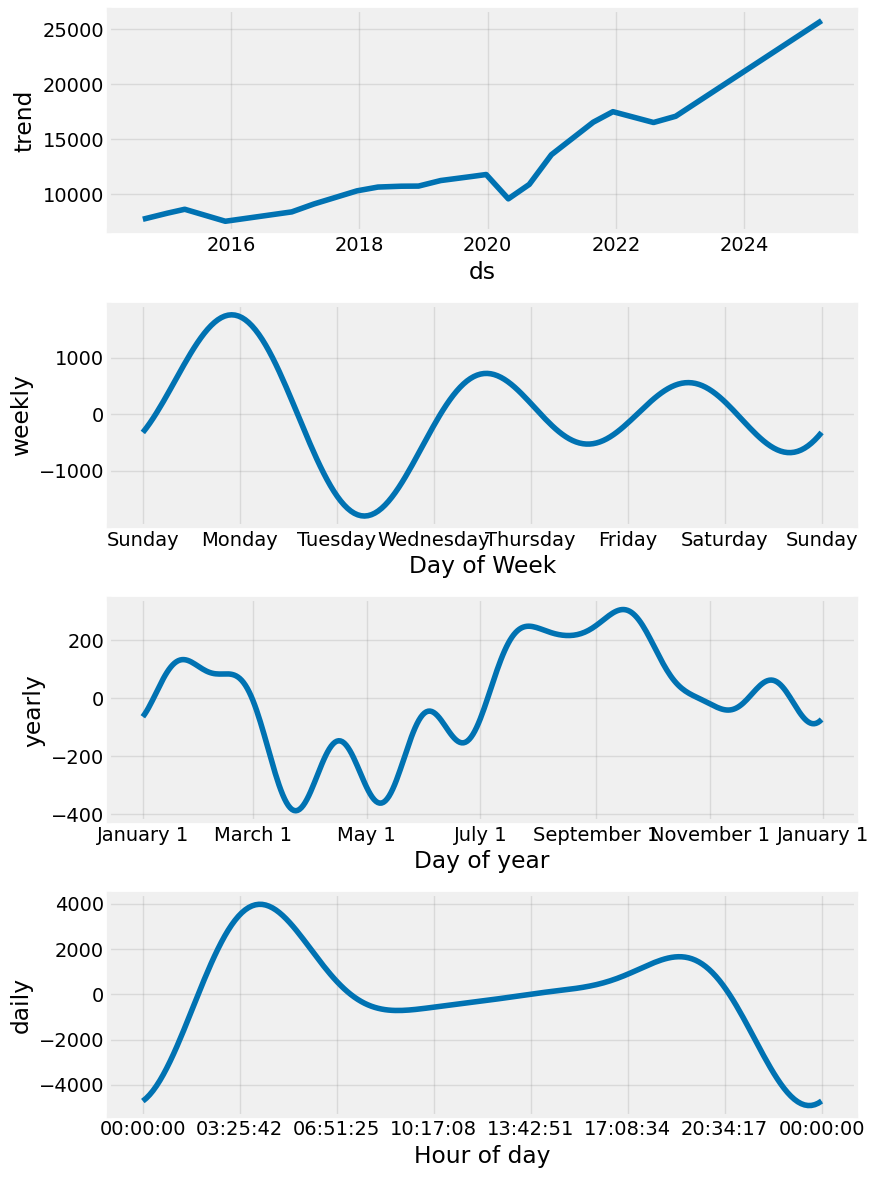

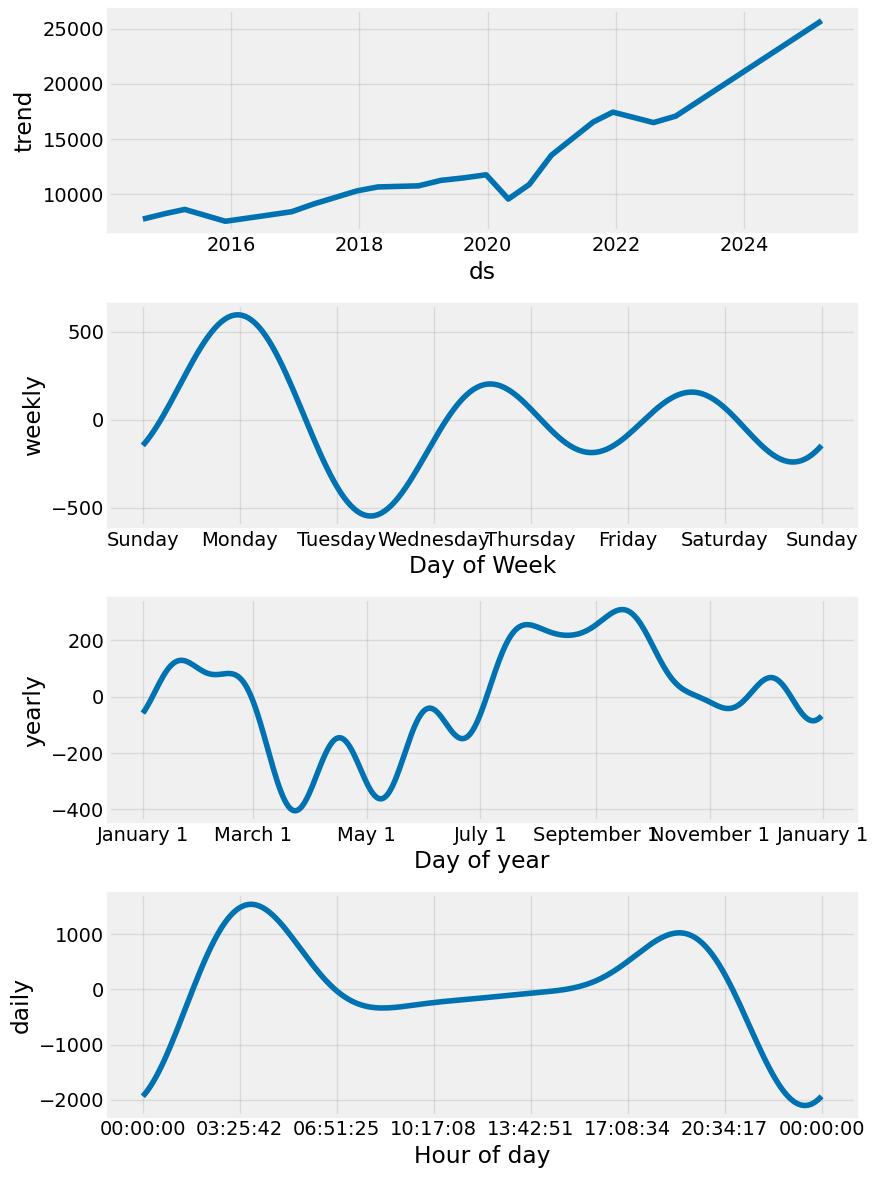


Weekly Forecasts (Monday to Thursday):
   week_num  week_start    week_end  highest_high   lowest_low        range
0         1  2014-08-18  2014-08-21   8755.295344  7337.919562  1417.375782
1         2  2014-08-25  2014-08-28   8769.021420  7439.334513  1329.686906
2         3  2014-09-01  2014-09-04   8845.492617  7462.651735  1382.840883

Weekly Forecasts (Monday to Thursday):
   week_num  week_start    week_end  highest_high   lowest_low        range
0         1  2014-08-18  2014-08-21   8754.390129  7340.535750  1413.854379
1         2  2014-08-25  2014-08-28   8837.355089  7370.313517  1467.041572
2         3  2014-09-01  2014-09-04   8824.876394  7448.280048  1376.596346


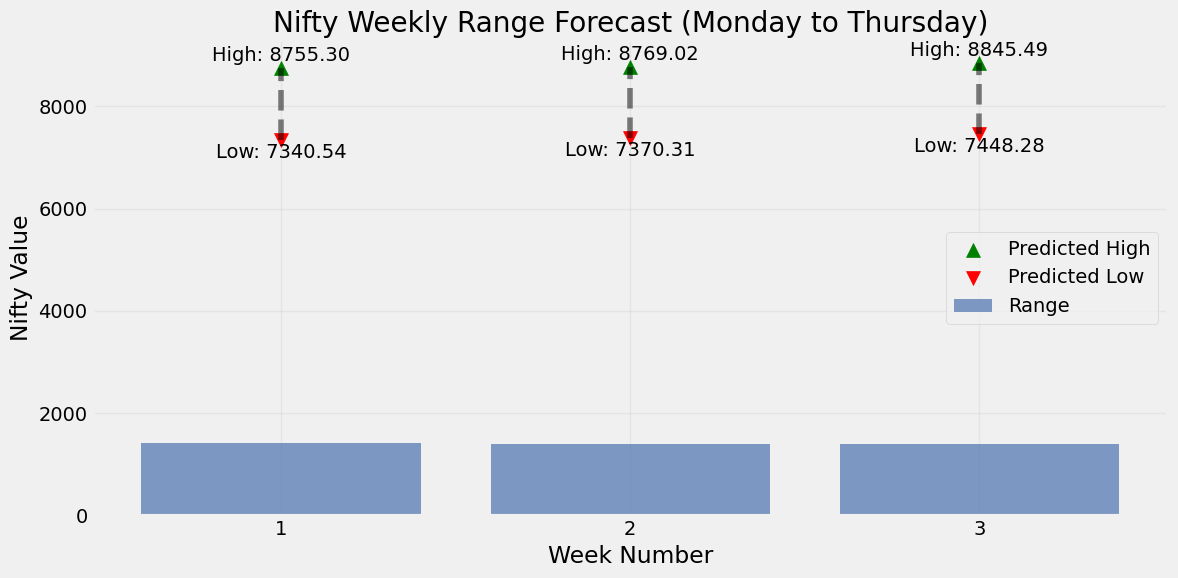

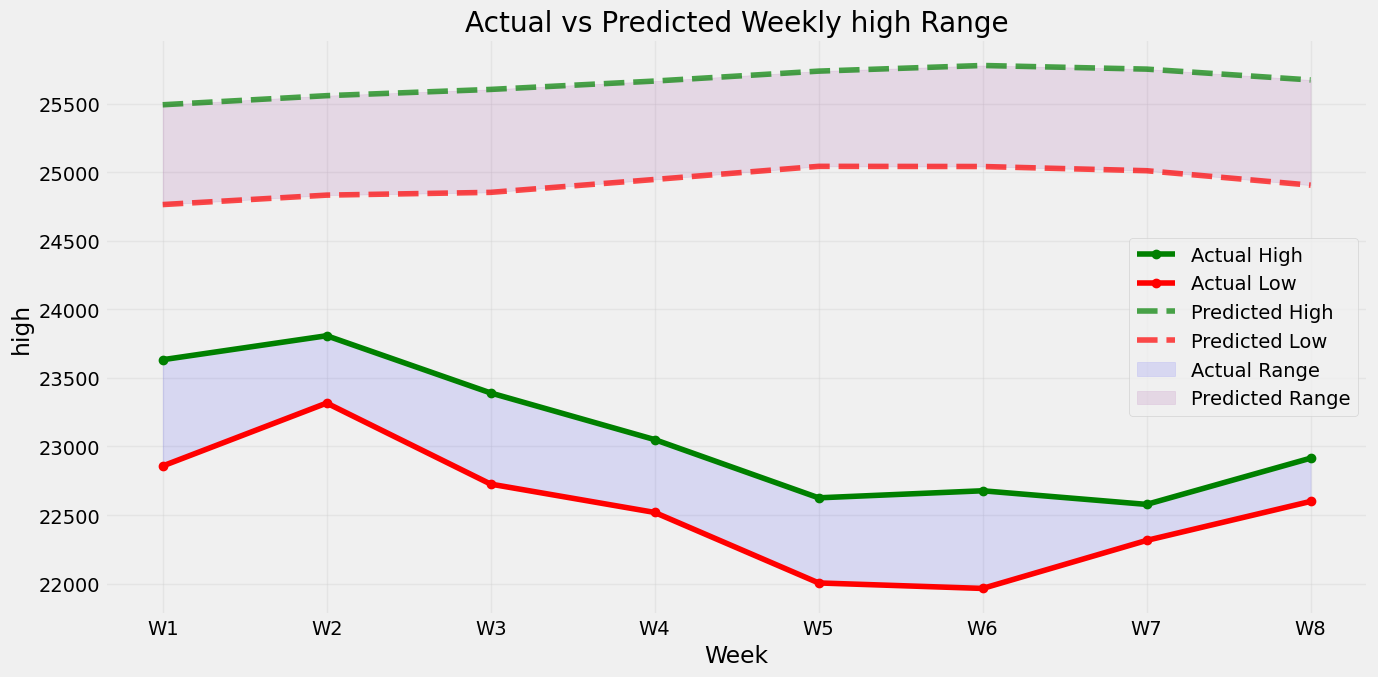

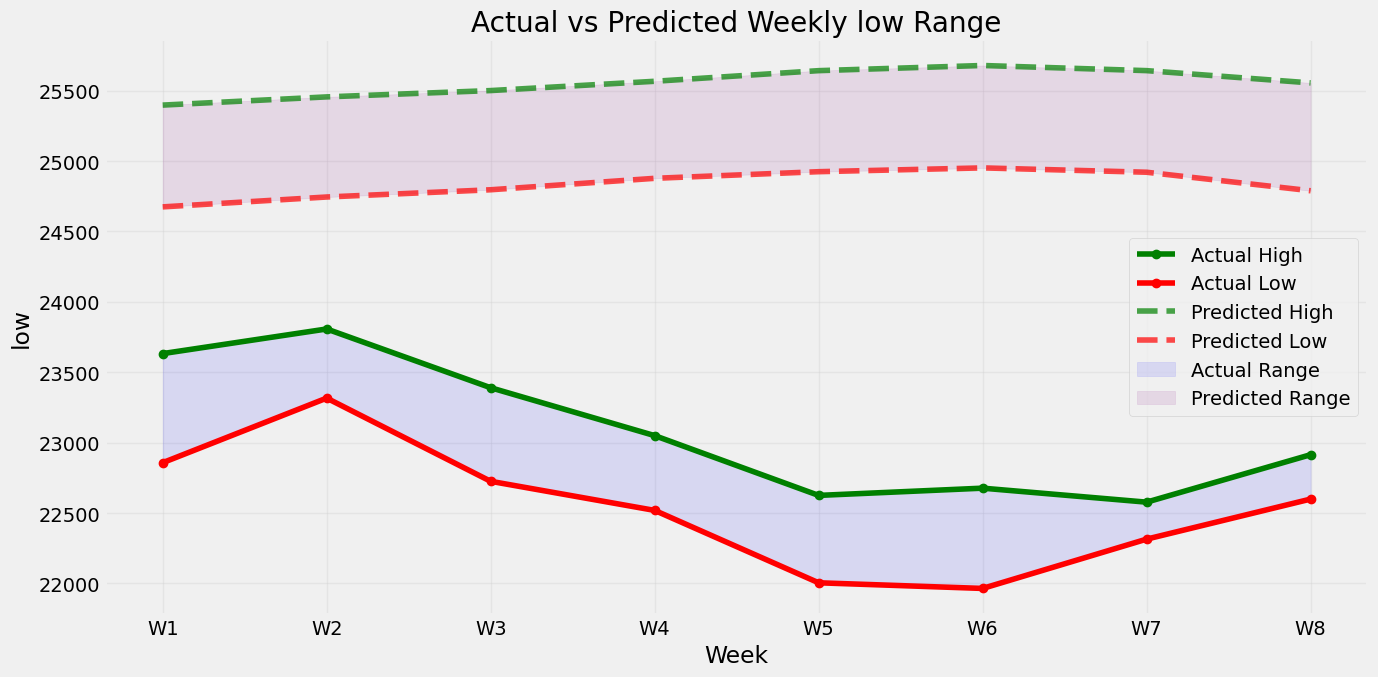


Making predictions based on current Nifty value: 22100.0

Weekly Forecasts Based on User Input (Monday to Thursday):
   week_num  week_start    week_end  highest_high    lowest_low        range
0         1  2014-08-18  2014-08-21  23897.664488  20157.335445  3740.329043
1         2  2014-08-25  2014-08-28  24085.796550  20258.412899  3827.383651
2         3  2014-09-01  2014-09-04  24192.066137  20437.241063  3754.825074


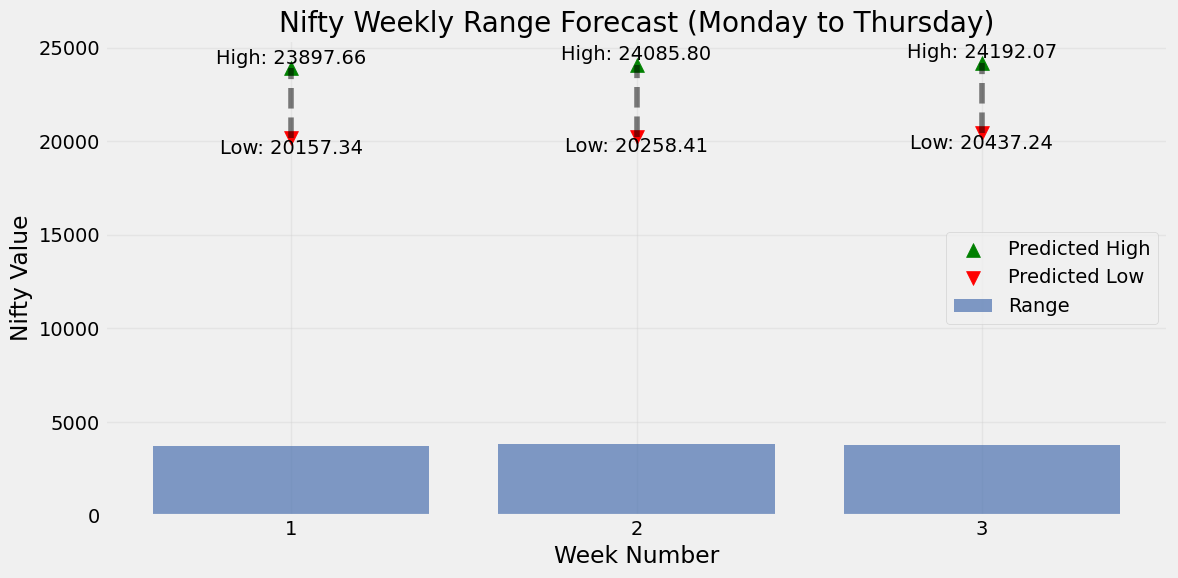

In [11]:

# Main execution
if __name__ == "__main__":
    # File path for Nifty data
    file_path = "/Users/priyeshgupta/ml_framework/data/raw/nifty_data.csv"  # Replace with your actual file path
    
    # Load data
    df = load_data(file_path)
    
    # Display sample data
    display_sample_data(df)
    
    # Extract insights
    df_day, df_week = extract_insights(df)
    
    # Filter Monday data
    monday_df = filter_monday_data(df)
    
    # Set training end date (last 2 months as test data)
    train_end_date = df['datetime'].max() - pd.Timedelta(days=60)
    
    # Train high model
    high_model, high_train_df, high_test_df = train_prophet_model(
        monday_df, 'high', train_end_date
    )
    
    # Train low model
    low_model, low_train_df, low_test_df = train_prophet_model(
        monday_df, 'low', train_end_date
    )
    
    # Make predictions for high
    high_forecast = make_predictions(high_model, periods=60*24, freq='H')
    
    # Make predictions for low
    low_forecast = make_predictions(low_model, periods=60*24, freq='H')
    
    # Evaluate high model
    high_eval_df = evaluate_model(high_model, high_test_df, high_forecast)
    
    # Evaluate low model
    low_eval_df = evaluate_model(low_model, low_test_df, low_forecast)
    
    # Plot forecast results
    plot_forecast(high_model, high_forecast, monday_df, 'high', train_end_date)
    plot_forecast(low_model, low_forecast, monday_df, 'low', train_end_date)
    
    # Plot components
    plot_components(high_model, high_forecast)
    plot_components(low_model, low_forecast)
    
    # Generate weekly forecasts
    high_weekly_df, high_complete_forecast = generate_weekly_forecasts(high_model)
    low_weekly_df, low_complete_forecast = generate_weekly_forecasts(low_model)
    
    # Combine high and low forecasts
    weekly_combined = high_weekly_df.copy()
    weekly_combined['lowest_low'] = low_weekly_df['lowest_low']
    weekly_combined['range'] = weekly_combined['highest_high'] - weekly_combined['lowest_low']
    
    # Plot weekly ranges
    plot_weekly_ranges(weekly_combined)
    
    # Plot actual vs predicted
    plot_actual_vs_predicted(high_eval_df, df, 'high')
    plot_actual_vs_predicted(low_eval_df, df, 'low')
    
    # Get user input
    try:
        current_nifty = float(input("\nEnter current Nifty value for custom predictions: "))
        # Make predictions based on user input
        user_weekly_df, user_forecast = predict_for_user_input(high_model, current_nifty)
    except ValueError:
        print("Invalid input. Skipping custom predictions.")